### Testing the Disjoint LinUCB Li's algorithm - Msc Project

Markos Flavio B. G. O.

__Context: contextual bandits.__

The objective of this notebook is to test the general behavior of the Disjoint LinUCB algorithm of policy adaptation and reward maximization proposed by [1].
    
__Specific objectives__

    1. Checking the tracking ability of the algorithm to fit linear reward funcitons with threshold zero
      1.1 Defining the client's algorithm
      1.2 Checking the tracking ability without noise
      1.3 Checking the tracking ability with noise
    2. Checking the tracking ability of the algorithm to fit linear reward functions with threshold different than zero
      2.1  Without the polynomial transformation (plain algorithm)
      2.2  With the polynomial transformation
      2.3  Noise study
    3. Checking the tracking ability to fit nonlinear functions
      3.1  Noise study
    4. Checking the action-selection mechanism of the algorithm
      4.1 Checking algorithm's ability to converge given different contexts
      4.2  Checking algorithm's sensitivity to alpha and noise (to do)    

In [1]:
# adding the .py path to be visible to this program
import sys
import time
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
sys.path.append(r'C:\Dropbox\_Studies\_Python Scripts\MSC\Spyder')
import linucb_v2 as lucb
reload(lucb) # so that changes in .py can be observed by this notebook without kernel disconnection.

<module 'linucb_v2' from 'C:\\Dropbox\\_Studies\\_Python Scripts\\MSC\\Spyder\\linucb_v2.py'>

### 1. Checking the tracking ability of the algorithm to fit linear reward funcitons with threshold zero

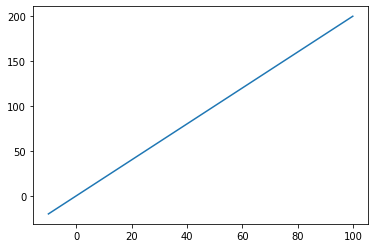

In [2]:
# defining a general line that simulates the reward function (y) according to contexts (x) of a single arm.
# that's the underlying function that needs to be learned.
x = np.arange(-10, 100, 0.1)
y = 2*x
plt.plot(x, y); plt.show()

#### 1.1 Defining the client's algorithm

In [3]:
# setting the disjoint bandit for the single arm a:
def testing_disjLinUCB(x, y, alpha, poly, noise=0, T=10):

    lucb.initializeLinUcbDisjoint(alpha, 1, poly) # d=1
    
    # create the arm
    a = lucb.LinUcbDisjoint()

    seq_models = []; seq_contexts = []; seq_rewards = []
    for t in range(T):
        idx = random.choice(list(range(len(x)))) # generating a sample of the line
        sx = x[idx]; context = np.array([[x[idx]]])
        sy = y[idx];
        
        # evalauting the reward
        correct_reward = sy # scalar
        reward = np.random.normal(correct_reward, noise)
        
        a.update_context(context)
        a.evaluate_theta() # the initial theta is a dxd zero matrix.
        a.evaluate_ucb()
        a.update_A()
        a.update_b(reward)
        
        seq_models.append(a.theta)
        seq_contexts.append(sx)
        seq_rewards.append(sy)
        
    return seq_models, seq_contexts, seq_rewards

#### 1.2 Checking the tracking ability without noise

In [4]:
poly = {"Degree": 1, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": False}

In [5]:
thetas, ctxs, rws = testing_disjLinUCB(x, y, 0.1, poly, noise=0)

Check bellow that after the first iteration the model was able to approach the underlyng linear model exaclty (the difference is due to regularization term).

In [6]:
print([t for t in thetas])

[array([[0.]]), array([[1.99979962]]), array([[1.99980206]]), array([[1.99980281]]), array([[1.99987875]]), array([[1.99991325]]), array([[1.99991597]]), array([[1.99993388]]), array([[1.99994151]]), array([[1.99994157]])]


#### 1.3 Checking the tracking ability with noise

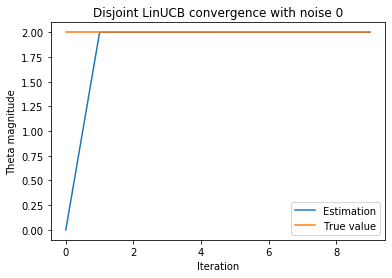

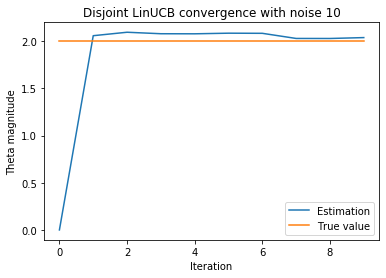

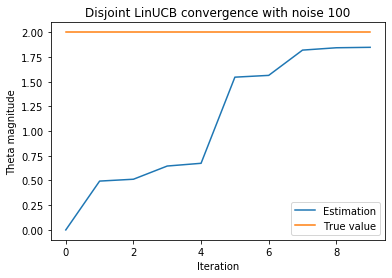

In [7]:
def conv_plot_noise(noise):
    thetas, ctxs, rws = testing_disjLinUCB(x, y, 0.1, poly, noise)
    plt.title('Disjoint LinUCB convergence with noise {0}'.format(str(noise)))
    plt.plot([t[0] for t in thetas], label = 'Estimation')
    plt.plot(2*np.ones(len([t[0] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Theta magnitude')
    plt.show()
conv_plot_noise(0)
conv_plot_noise(10)    
conv_plot_noise(100) 

### 2. Checking the tracking ability of the algorithm to fit linear reward functions with thresholds different than zero

#### 2.1 Without the polynomial transformation (plain algorithm)

In [8]:
poly = {"Degree": 1, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": False}

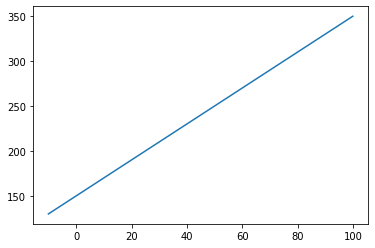

In [9]:
y = 2*x + 150
plt.plot(x, y); plt.show()

In [10]:
thetas, cxs, rws = testing_disjLinUCB(x, y, 0.1, poly, T=100)
thetas = [t[0][0] for t in thetas]
print(thetas[-10:])

[4.146486524962421, 4.138287690274097, 4.141587038834106, 4.12506548303426, 4.10767034240396, 4.1140450090570395, 4.111066532973166, 4.118764112550248, 4.112871041404883, 4.105665205036893]


Computing the errors between the model and the correct values generated by the underlying linear function.

(0, 200)

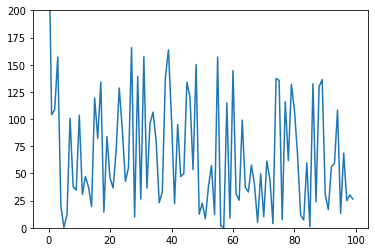

In [11]:
errors = [np.abs(t*c - r) for t, c, r in zip(thetas, cxs, rws)]
plt.plot(errors); plt.ylim(0, 200)

After a few iterations the error goes to a sort of average error, around 100, because the data is noiseless. However, it does not converges to zero. Depending on the context, the dependence on the threshold is higher and consequently the error. See the differences between the unerlying curve and the funciton approximated by the algorithm with the last observed theta.

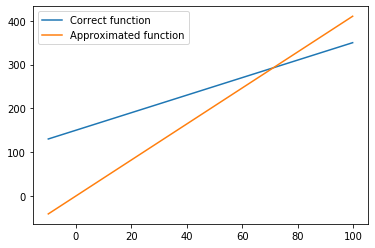

In [12]:
plt.plot(x, y, label='Correct function')
plt.plot(x, thetas[-1]*x, label='Approximated function')
plt.legend()

Note that in some regions of the "context space", the model is less accurate.
Naturally, as we increase the parameter 'b' the more is the difference between the aproximation and the linear function.

#### 2.2 With the polynomial transformation

To model a general line we must include in each context a single value equals one; *d* will become 2 inside the Class now because we're going to include the bias term.

In [13]:
poly = {"Degree": 1, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": True}

In [14]:
thetas, cxs, rws = testing_disjLinUCB(x, y, 0.1, poly, T=100)

Computing the errors:

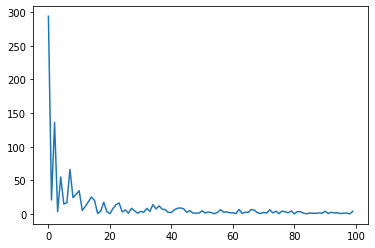

In [15]:
errors = [np.abs((t[1][0]*c + t[0][0]) - r) for t, c, r in zip(thetas, cxs, rws)] # t[0][0] is 'b' and t[1][0] is 'a'
plt.plot(errors); #plt.ylim(0, 200)

Note how the error converges to zero very quickly now. The high error at the beginning that exists even though the data have any noise, is due to the L2 constraint of the model. The constraint is a L2 regularization which adds penalty to the model equals the square of the magnitude of coefficients. That's not ideal in this simple noiseless scenario, but it's powerful in a general problem in which rewards come with noise.

See below the output of the model at the first iteration.

In [16]:
print('Model output:', cxs[1]*thetas[1][1][0] + thetas[1][0][0])
print('Target value:', rws[1])
print('Error:', np.abs(cxs[1]*thetas[1][1][0] + thetas[1][0][0] - rws[1]))

Model output: 335.16907057462333
Target value: 314.19999999999936
Error: 20.96907057462397


Now, the penalty of the 'correct line' is constant, however, as more data is gathered, less is the error of this correct linear model with respect to all points. And then, the error decreases.

Let's look at the appoximation of the last model.

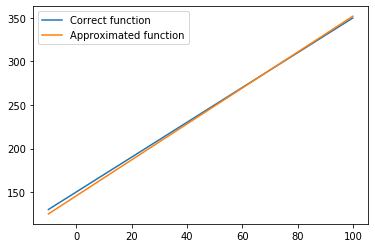

In [17]:
plt.plot(x, y, label='Correct function')
plt.plot(x, thetas[-1][1][0]*x + thetas[-1][0][0], label='Approximated function')
plt.legend()

A much better fit.

#### 2.3 Noise study

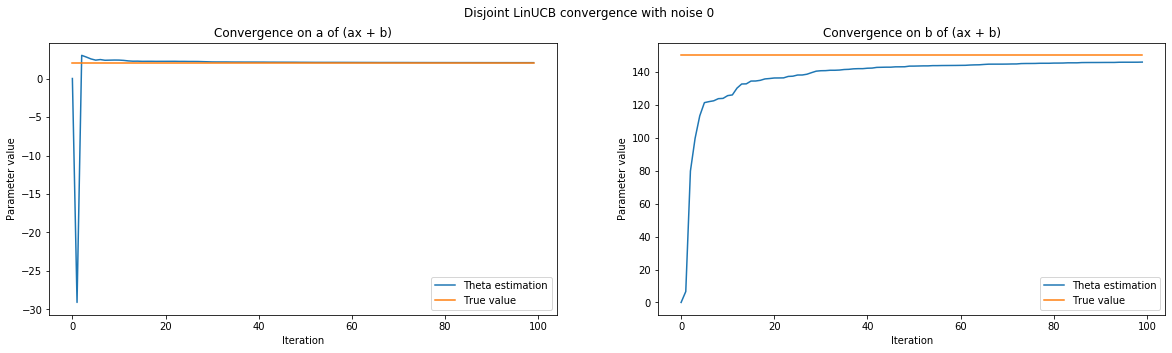

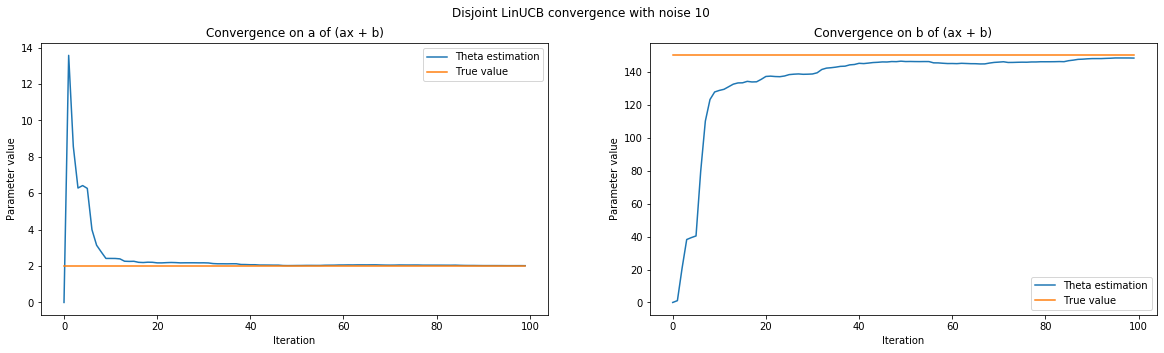

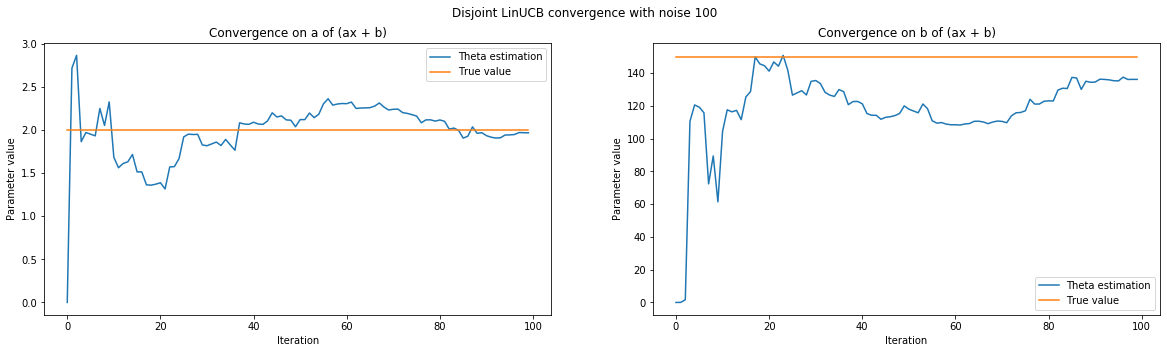

In [18]:
def conv_plot_noise(noise):
    thetas, ctxs, rws = testing_disjLinUCB(x, y, 0.1, poly, noise, T=100)
    plt.figure(figsize=(20,5))
    plt.suptitle('Disjoint LinUCB convergence with noise {0}'.format(str(noise)))
    plt.subplot(1,2,1)
    plt.title('Convergence on a of (ax + b)')
    plt.plot([t[1] for t in thetas], label = 'Theta estimation')
    plt.plot(2*np.ones(len([t[1] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    plt.subplot(1,2,2)
    plt.title('Convergence on b of (ax + b)')
    plt.plot([t[0] for t in thetas], label = 'Theta estimation')
    plt.plot(150*np.ones(len([t[0] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    plt.show()
conv_plot_noise(0)
conv_plot_noise(10)    
conv_plot_noise(100) 

### 3. Checking the tracking ability to fit nonlinear functions

Consider that the expected reward now is a quadratic function of the context.

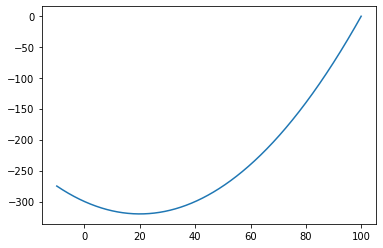

In [19]:
x = np.arange(-10, 100, 0.1)
y = 0.05*x**2 -2*x - 300
plt.plot(x, y); plt.show()

Naturally, a line would not fit such function very well, so we need to define a high dimensional model maintaining the linearity between the reward and the parameters.

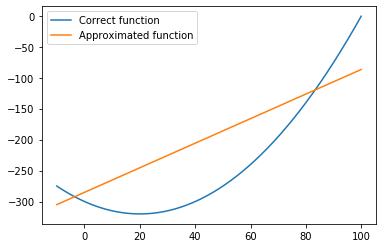

In [20]:
poly = {"Degree": 1, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": True}

thetas, cxs, rws = testing_disjLinUCB(x, y, 0.1, poly, T=10)
plt.plot(x, y, label='Correct function')
plt.plot(x, thetas[-1][1][0]*x + thetas[-1][0][0], label='Approximated function')
plt.legend()

To increase the 'fitting power' of our existing model, we add another context value, related to the 2nd-order relationship between the context and the reward. This occurs inside the LinUcbDisjoint Class.

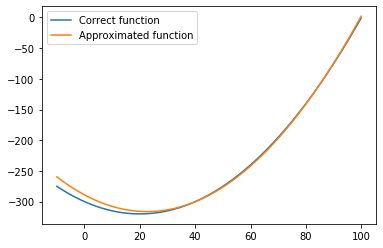

In [21]:
poly = {"Degree": 2, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": True} # all terms of higher-order terms are modeled if False
thetas, cxs, rws = testing_disjLinUCB(x, y, 0.1, poly, T=100)
plt.plot(x, y, label='Correct function')
plt.plot(x, (x**2)*thetas[-1][2][0] + thetas[-1][1][0]*x + thetas[-1][0][0], label='Approximated function')
plt.legend()

#### 3.1 Noise study

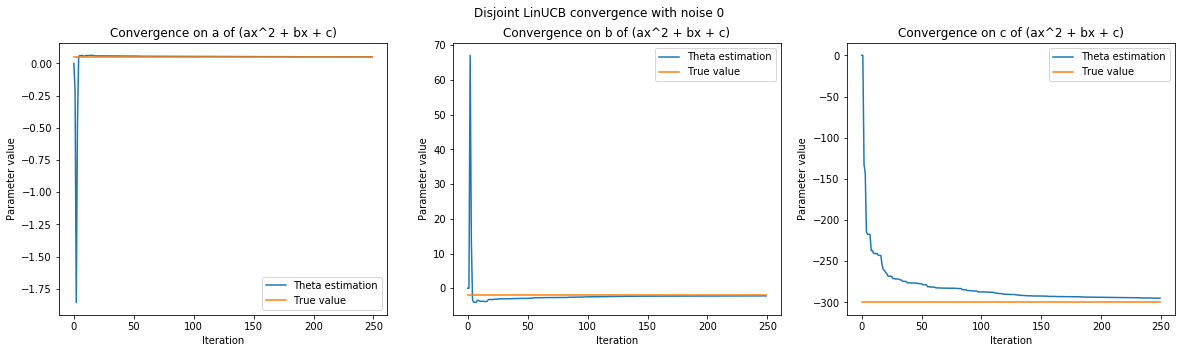

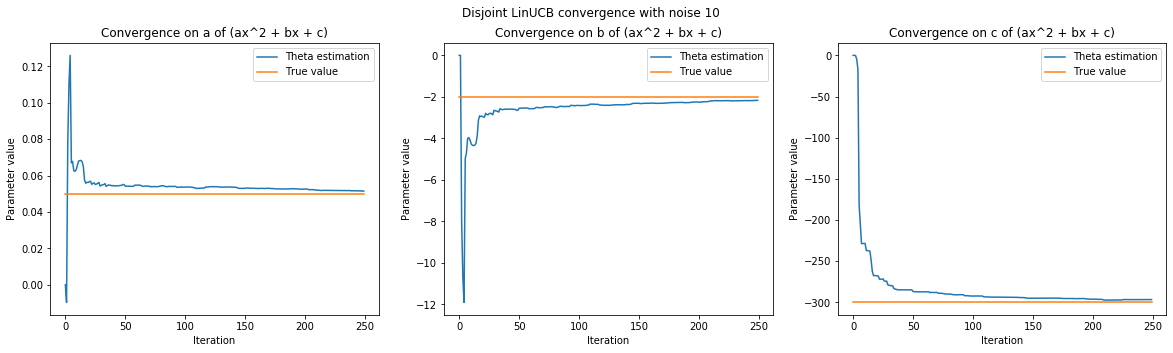

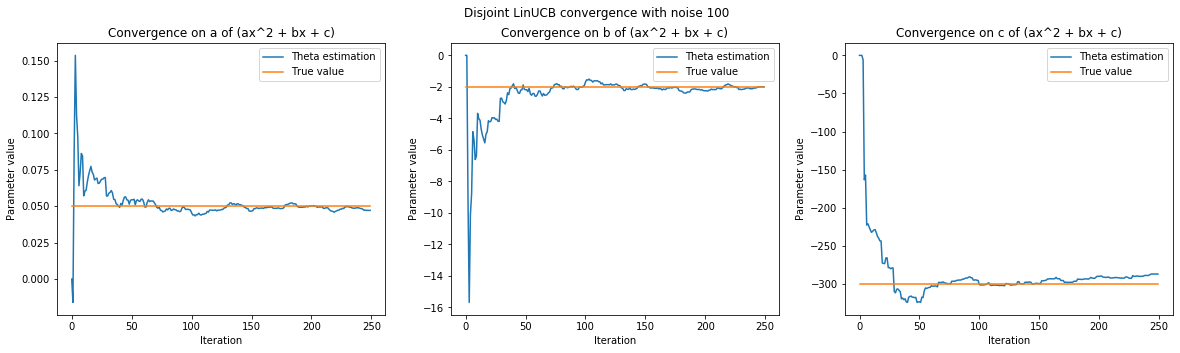

In [22]:
def conv_plot_noise(noise):
    thetas, ctxs, rws = testing_disjLinUCB(x, y, 0.1, poly, noise, T=250)
    plt.figure(figsize=(20,5))
    plt.suptitle('Disjoint LinUCB convergence with noise {0}'.format(str(noise)))
    plt.subplot(1,3,1)
    plt.title('Convergence on a of (ax^2 + bx + c)')
    plt.plot([t[2] for t in thetas], label = 'Theta estimation')
    plt.plot(0.05*np.ones(len([t[2] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    
    plt.subplot(1,3,2)
    plt.title('Convergence on b of (ax^2 + bx + c)')
    plt.plot([t[1] for t in thetas], label = 'Theta estimation')
    plt.plot(-2*np.ones(len([t[1] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    
    plt.subplot(1,3,3)
    plt.title('Convergence on c of (ax^2 + bx + c)')
    plt.plot([t[0] for t in thetas], label = 'Theta estimation')
    plt.plot(-300*np.ones(len([t[0] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    
    plt.show()

conv_plot_noise(0)
conv_plot_noise(10)
conv_plot_noise(100) 

Convergence still occurs for different levels of noise, but more iterations are needed.

### 4. Checking the action-selection mechanism of the algorithm

#### 4.1 Checking algorithm's ability to converge given different contexts

Tracking is working properly. Let's not see if the algorithm can correctly select the best actions actions given different contexts. Given a context, the algorithm should select the action whose expected reward in that context is maximized.

We'll consider three arms with different context-reward relationships. We'll consider rewards within a range that we expect in our problem, something between 0 and 1000.

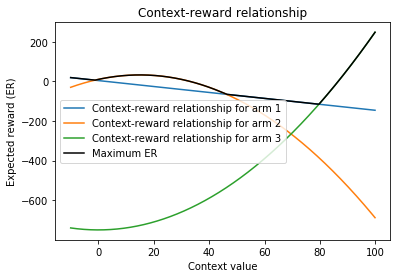

In [23]:
x = np.arange(-10, 100, 0.1)
c1 = -1.5*x + 4
c2 = -0.1*x**2 + 3*x + 10
c3 = 0.1*x**2 -750
#c1 = -15*x + 4000
#c2 = -2*x**2 + 5000
#c3 = x**2 - 10*x + 5
maximum = np.array([max(a,b,c) for a, b, c in zip(c1, c2, c3)])
plt.title('Context-reward relationship')
plt.plot(x, c1, label = 'Context-reward relationship for arm 1')
plt.plot(x, c2, label = 'Context-reward relationship for arm 2')
plt.plot(x, c3, label = 'Context-reward relationship for arm 3')
plt.plot(x, maximum, label= 'Maximum ER', c='k')
plt.ylabel('Expected reward (ER)')
plt.xlabel('Context value')
plt.legend()
plt.show()

At any context value there will be at least one arm that's better:
 - [10, 0] range: arm 1
 - [0, 45] range: arm 2
 - [45, 80] range: arm 1
 - [80, 100] range: arm 3

In [24]:
def testing_disjLinUCB_multiple_arms(x, Y, alpha, poly, noise=0, T=10):

    lucb.initializeLinUcbDisjoint(alpha, 1, poly)
    
    # create the arms
    arms = []
    for arm in Y:
        arms.append(lucb.LinUcbDisjoint())

    seq_models = []; seq_contexts = []; seq_rewards = []; seq_actions = []
    for t in range(T):
        idx = random.choice(list(range(len(x))))
        context = np.array([[x[idx]]])
        
        thetas = [] # exporting
        for i, a in enumerate(arms):
            a.update_context(context)
            a.evaluate_theta() # the initial theta is a dxd zero matrix.
            thetas.append(a.theta)
            a.evaluate_ucb() 
        ucb_values = np.array([a.ucb for a in arms])
        aidx = np.random.choice(np.flatnonzero(ucb_values == ucb_values.max()))
        
        # evalauting the reward
        correct_reward = Y[aidx][idx] # scalar
        reward = np.random.normal(correct_reward, noise)
        
        arms[aidx].update_A()
        arms[aidx].update_b(reward)
        
        seq_models.append(thetas)
        seq_contexts.append(idx)
        seq_rewards.append(reward)
        seq_actions.append(aidx+1) # change arm '0' to '1'
        
    return seq_models, seq_contexts, seq_rewards, seq_actions

We're going to model all relationships with 2nd-order curves. Even though, the relationship between contexts and rewards for arm 1 is given by a line. In real world problem this isn't known.

In [25]:
poly = {"Degree": 2, # degree of nonlinearity
        "Loose interaction": False,
        "Bias": True}

The magnitude of the *alpha* depends on the range of reward values. As we increase the order of magnitude of the rewards, the estimates will also be increased and a higher alpha is needed to provide exploration according to UCB values.

Let's now check the curves being learned by the arms together with the data points. To do that, run the following cell with a few different values for alpha: 1, 100 and 10000. Remember that the proper values of alpha depends on the reward values being sampled.

In [27]:
def draw_learned_curves(thetas, ctxs, rws, acts, underlying):
    
    # sperating the data according to which action was chosen
    t1 = []; t2 = []; t3 = []; c1 = []; c2 = []; c3 = []; r1 = []; r2 = []; r3 = []
    for t, c, r, a in zip(thetas, ctxs, rws, acts):
        if a==1:
            c1.append(c)
            r1.append(r)
        elif a==2:
            c2.append(c)
            r2.append(r)
        else: # a==3
            c3.append(c)
            r3.append(r)
        t1.append(t[0]); t2.append(t[1]); t3.append(t[2])
    
    ts = [t1, t2, t3]; cs = [c1, c2, c3]; rs = [r1, r2, r3]
    # drawing the final curves with the data points
    x = np.arange(-10, 100, 0.1)
    colors = ['b', 'darkorange', 'g']
    for i, c in enumerate(colors):
        plt.title('Curve fitting for arm {0}'.format(i+1))
        plt.plot(x[cs[i]], rs[i], '*', c='r')
        plt.xlabel("Contexts"); plt.ylabel("Rewards")
        plt.plot(x, ts[i][-1][0][0] + ts[i][-1][1][0]*x + ts[i][-1][2][0]*x*x, c='k') 
        plt.plot(x, underlying[i], c=c)
        plt.show()

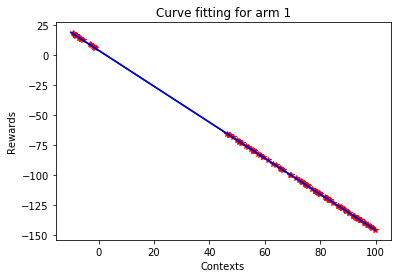

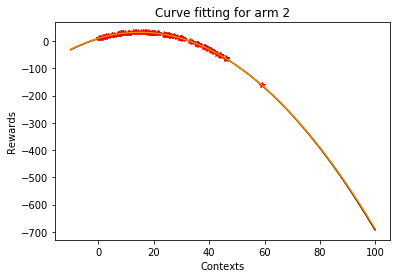

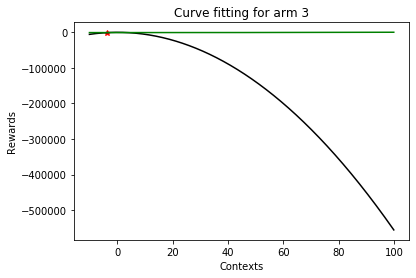

In [44]:
Y=[c1, c2, c3]
thetas, ctxs, rws, acts = testing_disjLinUCB_multiple_arms(x, Y, alpha=1, poly=poly, noise=0, T=200)
draw_learned_curves(thetas, ctxs, rws, acts, [c1, c2, c3])

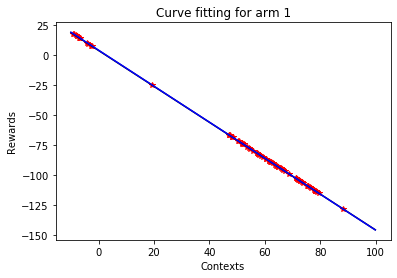

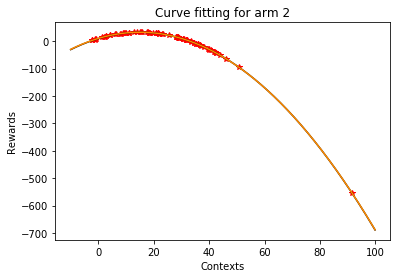

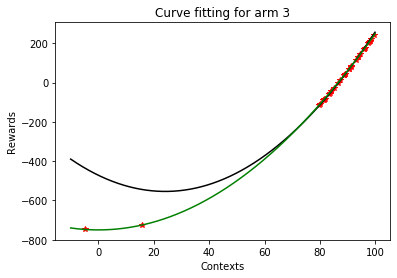

In [30]:
thetas, ctxs, rws, acts = testing_disjLinUCB_multiple_arms(x, Y, alpha=100, poly=poly, noise=0, T=200)
draw_learned_curves(thetas, ctxs, rws, acts, [c1, c2, c3])

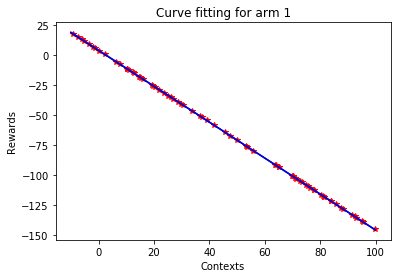

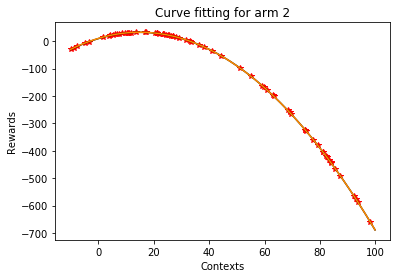

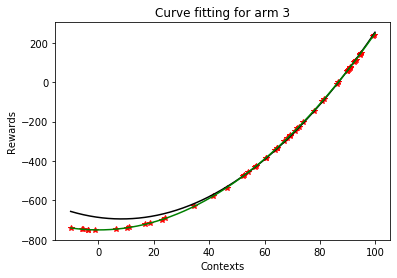

In [31]:
Y=[c1, c2, c3]
thetas, ctxs, rws, acts = testing_disjLinUCB_multiple_arms(x, Y, alpha=10000, poly=poly, noise=0, T=200)
draw_learned_curves(thetas, ctxs, rws, acts, [c1, c2, c3])

Note the common behavior that appears:
  - If alpha is small (~1) arm 3 relationship is poorly modeled. This occurs because the data relies to much on the estimate of the models being learned, even if only a few data points were presented to them. The model starts fitting the points and still being used to generate estimates. If the initial parameters are very poor, the models will generate very wrong estimates. As this estimates are being used and trusted too much, some models will never be corrected because exploration is avoided with such low value for alpha. 
  - If alpha is large (~100) arm 3 relationship can be partially modeled; however, more trials are selected for exploration. Note how the first part of the curve is not matching with the correct behavior. However, modeling this part correctly is not important because the two other arms have a large performance compared to arm 3 in this region. That's intelligence: not spending too much trials on poor regions! Note how there's a lack on data points in intermediary region of the linear model: that's because it's better to use the arm 2 in such region of contexts.
  - If alpha is hige (~10000) arm 3 relationmship is very modeled, however note how much data points on low context values the algorithm spends on it. That's not a good behavior: the algorithm is over exploring!

Let's check the best value for alpha in this problem in terms of the average reward gotten which is what really matters for us. For each value of alpha in the following array, we'll run 10 times the Disjoint LinUCB Algorithm and check the average reward obtained across these 10 runs. We'll maintain the noise at zero.

alphas = [0.1, 1, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]

In [32]:
x = np.arange(-10, 100, 0.1)
c1 = -1.5*x + 4
c2 = -0.1*x**2 + 3*x + 10
c3 = 0.1*x**2 -750
Y=[c1, c2, c3]

alphas = [0.1, 1, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
trials = 5
rewards = []
for alpha in alphas:
    print('Alpha = {0}'.format(str(alpha)))
    r_trials = []
    for t in range(trials):
        _, _, r, _ = testing_disjLinUCB_multiple_arms(x, Y, alpha=alpha, poly=poly, noise=0, T=200)
        r_trials.append(sum(r)/len(r))
        #print('Avg. r.', sum(r)/len(r))
    rewards.append(sum(r_trials)/len(r_trials))

Alpha = 0.1
Alpha = 1
Alpha = 10
Alpha = 50
Alpha = 100
Alpha = 250
Alpha = 500
Alpha = 1000
Alpha = 2500
Alpha = 5000
Alpha = 10000


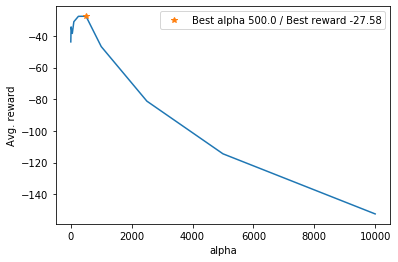

In [33]:
plt.plot(alphas, rewards); plt.xlabel("alpha"); plt.ylabel("Avg. reward");
best_alpha = np.array(alphas)[np.array(rewards)==max(np.array(rewards))][0]
best_reward = max(np.array(rewards))
plt.plot(best_alpha, best_reward, '*', label='Best alpha {0} / Best reward {1}'.format(best_alpha, np.round(best_reward, 2)))
plt.legend()

The high variance we obeserve for low values of alpha is due to the fact that the fitting models and the corresponding performance is too much dependent on the initial context values that are being sampled.

We can see that the best alpha is around 50. Even though the fitting is not ideal in this case, that's not really the goal here; it's to maximize the reward values across the trials.

Let's check the parameters learned by the models.

In [36]:
x = np.arange(-10, 100, 0.1)
c1 = -1.5*x + 4
c2 = -0.1*x**2 + 3*x + 10
c3 = 0.1*x**2 -750
maximum = np.array([max(a,b,c) for a, b, c in zip(c1, c2, c3)])

Y=[c1, c2, c3]

c1_max_idx = np.where(c1==maximum) # indices of metric space x where arm 1 is better
c2_max_idx = np.where(c2==maximum)
c3_max_idx = np.where(c3==maximum)

thetas, ctxs, rws, acts = testing_disjLinUCB_multiple_arms(x, Y, alpha=50, poly=poly, noise=0, T=200)

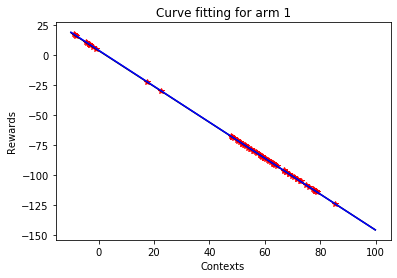

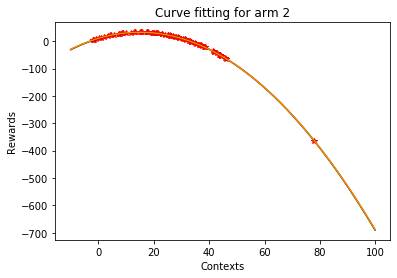

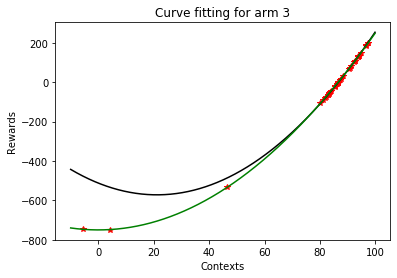

In [37]:
draw_learned_curves(thetas, ctxs, rws, acts, [c1, c2, c3])

Let's now check how the convergence occurs in terms of action-selection on different **regions** of contexts, where each region defines context values where each individual arm has a better performance.

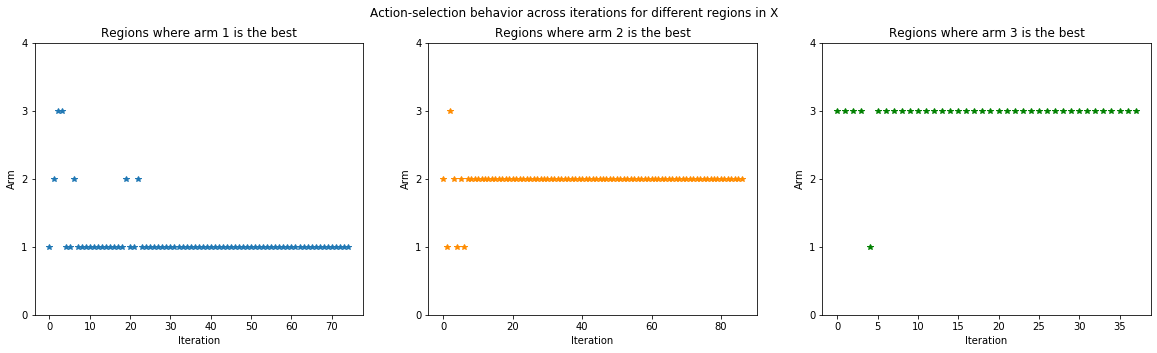

In [38]:
def plot_conv_actions(ctxs, acts):
    acts_region_c1 = []; acts_region_c2 = []; acts_region_c3 = []
    for c, a in zip(ctxs, acts):
        if c in c1_max_idx[0]:
            acts_region_c1.append(a)
        elif c in c2_max_idx[0]:
            acts_region_c2.append(a)
        elif c in c3_max_idx[0]:
            acts_region_c3.append(a)
        else:
            print("Error")
    plt.figure(figsize=(20,5))
    plt.suptitle("Action-selection behavior across iterations for different regions in X")
    plt.subplot(1,3,1)
    
    plt.plot(acts_region_c1, '*')
    plt.xlabel('Iteration'); plt.ylabel('Arm'); plt.yticks([0,1,2,3,4]); plt.title('Regions where arm 1 is the best')
    plt.subplot(1,3,2)
    plt.plot(acts_region_c2, '*', c='darkorange')
    plt.xlabel('Iteration'); plt.ylabel('Arm'); plt.yticks([0,1,2,3,4]); plt.title('Regions where arm 2 is the best')
    plt.subplot(1,3,3)
    plt.plot(acts_region_c3, '*', c='g')
    plt.xlabel('Iteration'); plt.ylabel('Arm'); plt.yticks([0,1,2,3,4]); plt.title('Regions where arm 3 is the best')
    plt.show()
    
plot_conv_actions(ctxs, acts)

The algorithm correctly converges to the correct arms given the contexts.

Below, we can see the convergence in the parameter values for all three arms across iterations.

In [39]:
arm1_evolution = []
arm2_evolution = []
arm3_evolution = []
for t in thetas:
    arm1_evolution.append(t[0])
    arm2_evolution.append(t[1])
    arm3_evolution.append(t[2])

In [40]:
def conv_plot_noise_multiple_arms(thetas, correct_values):
    plt.figure(figsize=(20,5))
    plt.suptitle('Disjoint LinUCB parameter\'s convergence')
    plt.subplot(1,3,1)
    plt.title('Convergence on a of (ax^2 + bx + c)')
    plt.plot([t[2] for t in thetas], label = 'Theta estimation')
    plt.plot(correct_values[2]*np.ones(len([t[2] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    
    plt.subplot(1,3,2)
    plt.title('Convergence on b of (ax^2 + bx + c)')
    plt.plot([t[1] for t in thetas], label = 'Theta estimation')
    plt.plot(correct_values[1]*np.ones(len([t[1] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    
    plt.subplot(1,3,3)
    plt.title('Convergence on c of (ax^2 + bx + c)')
    plt.plot([t[0] for t in thetas], label = 'Theta estimation')
    plt.plot(correct_values[0]*np.ones(len([t[0] for t in thetas])), label = 'True value')
    plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Parameter value')
    plt.show()

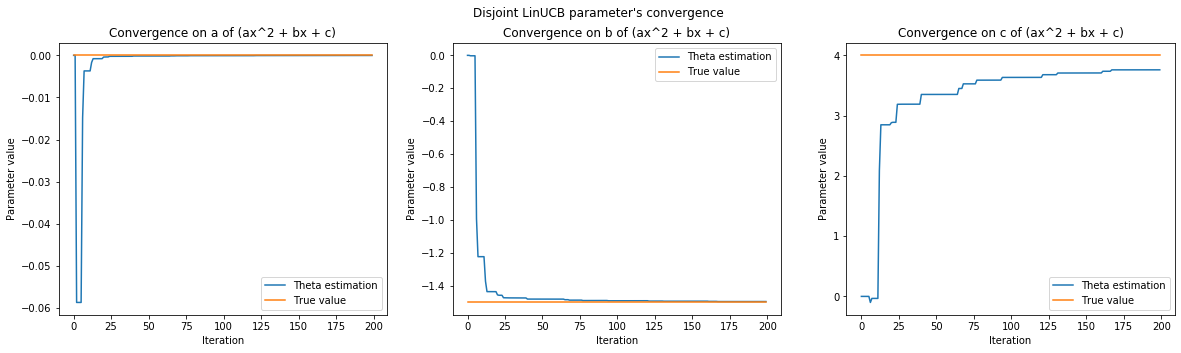

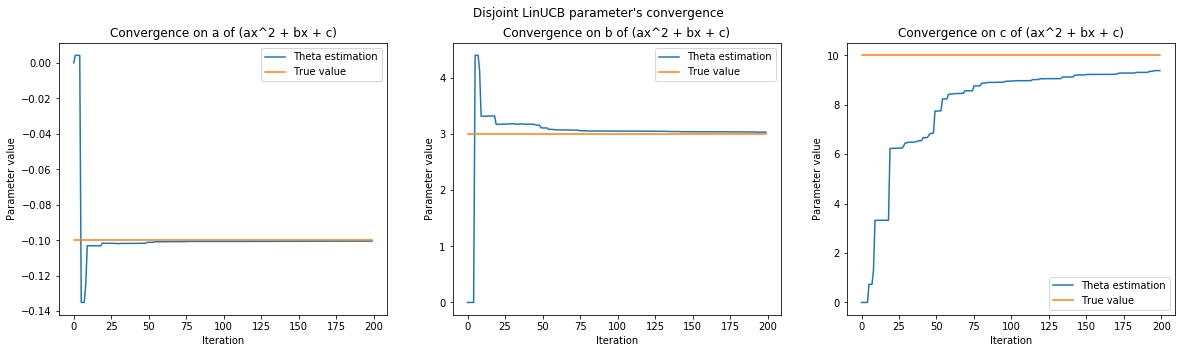

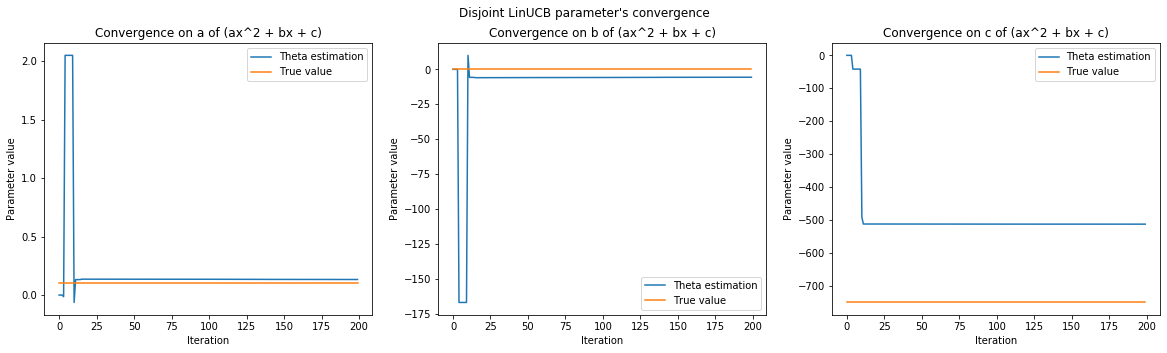

In [41]:
conv_plot_noise_multiple_arms(arm1_evolution, [4, -1.5, 0]) # arm 1 coeff.
conv_plot_noise_multiple_arms(arm2_evolution, [10, 3, -0.1]) # arm 2 coeff.
conv_plot_noise_multiple_arms(arm3_evolution, [-750, 0, 0.1]) # arm 3 coeff.

Let's now plot the learning process of arm 1 paramters across iteraions dynamically.

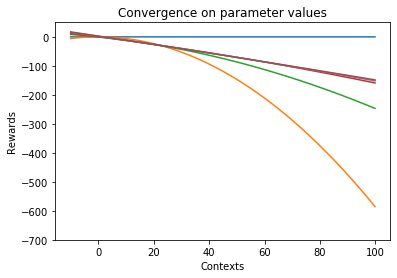

In [42]:
x = np.arange(-10, 100, 0.1)
fig = plt.figure()

# filtering the evolution to the trials that only arm 1 was selected
arm1e = np.array(arm1_evolution)
arm1e = arm1e[list(np.where(np.array(acts)==1)[0])]

oldt = [1000, 1000, 1000]
for i, t in enumerate(arm1e):
    #if i % 10 == 0:
    plt.ylim([-700, 50]); plt.ylabel("Rewards"); plt.xlabel("Contexts")
    plt.title("Convergence on parameter values")
    if abs((t[0]-oldt[0])**2 + (t[1]-oldt[1])**2 + (t[2]-oldt[2])**2) < 0.0001: # stops when convergence occurs
        break
    plt.plot(x, t[0] + t[1]*x + t[2]*x*x) #t[0] + t[1]*x + t[2]*x*x
    oldt = t
    #fig.canvas.clear()
    fig.canvas.draw()
    time.sleep(0.5)

#### 4.2 Checking algorithm's sensitivity to alpha and noise

1. Plot the action-selection behavior as shown above.
2. Plot the approximated functions in some key iteraions.
3. Plot the heatmap using accuracy as metric for different values of alpha and noise

### References

[1] LI, Lihong et al. A contextual-bandit approach to personalized news article recommendation. In: **Proceedings of the 19th international conference on World wide web**. 2010. p. 661-670.
